<a href="https://colab.research.google.com/github/ralph27/ZAKA-hands-on/blob/master/Arabic_Hate_Speech_Detection_with_AraBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hate Speech Detection with AraBERT
---
© 2023, Zaka AI, Inc. All Rights Reserved.


**Objective:** In this practical exercise, we will learn how to detect hate speech in the arabic language using the AraBERT model. We will use the AJGT Sentiment Analysis Dataset from the academic paper “Arabic tweets sentimental analysis using machine learning” by K. M. Alomari, H. M. ElSherif, and K. Shaalan.




#Installing Prerequisites

We will need the following dependencies:


**transformers**: Hugging Face transformers library, it provides pre-trained models for a wide range of natural language processing (NLP) tasks, such as text classification, translation, and more.

**farasapy**: Python library for Arabic text processing. It provides various NLP tools for working with Arabic text, including tokenization, stemming, and text cleaning. It is particularly useful for Arabic language processing tasks.

**pyarabic**: Python library for working with the Arabic language. It offers functionality for Arabic text normalization, tokenization, and other linguistic operations.

**arabert**: We will clone this repository into our machine so we can work with the AraBERT model.


In [ ]:
!pip install transformers[torch]
!pip install farasapy
!pip install pyarabic
!git clone https://github.com/aub-mind/arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.9 MB/s eta 0:00:00
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 600 (delta 38), reused 45 (delta 30), pack-reused 535
Receiving objects: 100% (600/600), 9.14 MiB | 27.45 MiB/s, done.
Resolving deltas: 100% (339/339), done.


We will also use numpy, pandas, sklearn and matplotlib, libraries that we are already familiar with.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers.data.processors.utils import InputFeatures
from transformers import AutoTokenizer

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from transformers.trainer_utils import EvaluationStrategy

from arabert.preprocess import ArabertPreprocessor

#Getting our Data


We will get the required AJGT dataset directly from its original github repository.

In [ ]:
!git clone https://github.com/komari6/Arabic-twitter-corpus-AJGT.git

Cloning into 'Arabic-twitter-corpus-AJGT'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (9/9), 102.95 KiB | 2.78 MiB/s, done.


We will first read the dataset

In [ ]:
#get data into a dafaframe
df_AJGT = pd.read_excel('/content/Arabic-twitter-corpus-AJGT/AJGT.xlsx',header=0)

df_AJGT[8:13]

,ID,Feed,Sentiment
8,9,اتحزن فان الله يدافع عنك والملائكه تستغفر لك و...,Positive
9,10,اترك ما تهوى لاجل من تخشى,Positive
10,11,اتصور لو ظليت ما اتعلق احسن لانه تعليقاتك مقرفه,Negative
11,12,اتفه على هيك برنامج عالمي,Negative
12,13,اتقوا الله فينا بكفي رفع اسعار الرواتب بالحضيض,Negative


Then arrange the columns names so they can be used by our model later on

In [ ]:
data_column = 'text'
label_column = 'label'

df_AJGT = df_AJGT[['Feed', 'Sentiment']]
df_AJGT.columns = [data_column, label_column]
df_AJGT.head()

,text,label
0,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...,Positive
1,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...,Negative
2,كله رائع بجد ربنا يكرمك,Positive
3,لسانك قذر يا قمامه,Negative
4,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...,Negative


Next, let's split the data into training and testing:

In [ ]:
data_train, data_test = train_test_split(df_AJGT, test_size=0.2,random_state=42)

We also need to check the sentence length to decide on the max_len value:

Train Sentence Lengths: 


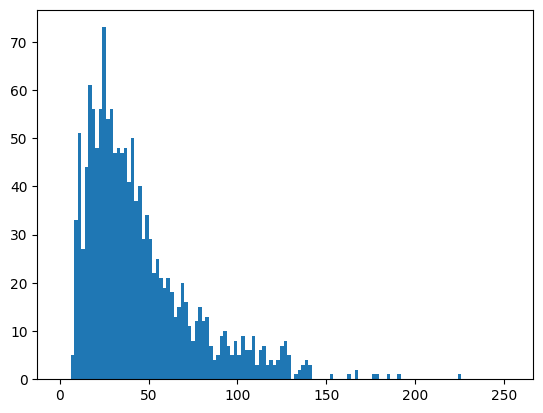

3
Test Sentence Lengths: 


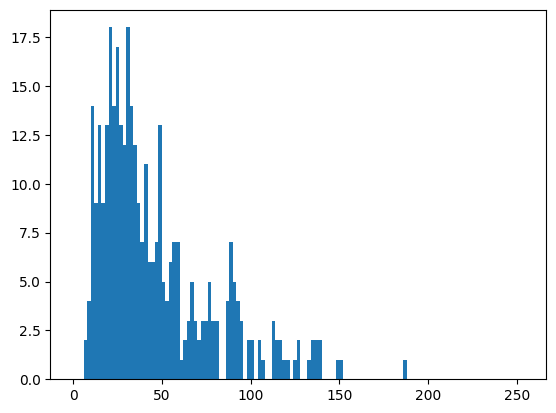

5


In [ ]:
print("Train Sentence Lengths: ")
plt.hist([ len(sentence) for sentence in data_train['text']],bins=range(0,256,2))
plt.show()
print(sum([len(sentence) > 256 for sentence in data_train['text']]))

print("Test Sentence Lengths: ")
plt.hist([ len(sentence) for sentence in data_test['text']],bins=range(0,256,2))
plt.show()
print(sum([len(sentence) > 256 for sentence in data_test['text']]))

We can now decide to use 256 as our max_len

#Training Requirements

Let's start by creating the dataset needed for training and testing, we will use the Dataset class from pytorch as our base class.

For tokenization, we will be using the autotokenizer from HuggingFace.

In [ ]:
# Define the Dataset class
class CustomDataset(Dataset):
  def __init__(self, texts, labels, model_name, max_len, label_map):
    # Hold the text and reviews inside the dataset class
    self.texts = texts
    self.labels = labels
    self.label_map = label_map
    self.tokenizer_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.max_len = max_len

  def __len__(self):
    #returns the length of the dataset
    return len(self.texts)

  def __getitem__(self, item):
    # Select the example based on the item ID
    text = str(self.texts[item])
    label = self.labels[item]

    input_dict = self.tokenizer(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding = 'max_length',
          truncation= True
      )

    return InputFeatures(input_ids=input_dict["input_ids"],
                         token_type_ids=input_dict['token_type_ids'],
                         attention_mask=input_dict["attention_mask"],
                         label=self.label_map[self.labels[item]])

We will also define the evaluation metrics that we will use:
- Macro F1 Score
- Macro Precision
- Macro Recall
- Accuracy

In [ ]:
def compute_metrics(pred):
  preds = np.argmax(pred.predictions, axis=1)
  assert len(preds) == len(pred.label_ids)
  macro_f1_pos_neg = f1_score(pred.label_ids,preds,average='macro',labels=[0,1])
  macro_f1 = f1_score(pred.label_ids,preds,average='macro')
  macro_precision = precision_score(pred.label_ids,preds,average='macro')
  macro_recall = recall_score(pred.label_ids,preds,average='macro')
  acc = accuracy_score(pred.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'macro_f1_pos_neg' : macro_f1_pos_neg,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': acc
  }

## Preprocessing the dataset
Let's start by defining the AraBERT preprocessor using the arabert library alongside HuggingFace.

In [ ]:
model_name = 'aubmindlab/bert-base-arabertv02'
arabert_prep = ArabertPreprocessor(model_name)

Next, we will apply preprocessing for the text column using the arabert preprocessor:

In [ ]:
data_train[data_column] = data_train[data_column].apply(lambda x: arabert_prep.preprocess(x))
data_test[data_column] = data_test[data_column].apply(lambda x: arabert_prep.preprocess(x))

Let's extract the label map to easily use it later

In [ ]:
label_list = list(data_test[label_column].unique())
label_map = { v:index for index, v in enumerate(label_list) }
label_map

{'Negative': 0, 'Positive': 1}

Now we are able to create the train and test for our CustomDataset:

In [ ]:
max_len = 256
train_dataset = CustomDataset(
    texts= data_train[data_column].to_list(),
    labels= data_train[label_column].to_list(),
    model_name= model_name,
    max_len= max_len,
    label_map= label_map
    )

test_dataset = CustomDataset(
    texts= data_test[data_column].to_list(),
    labels= data_test[label_column].to_list(),
    model_name= model_name,
    max_len= max_len,
    label_map= label_map
    )

# Setup the HuggingFace trainer

We will be using the "bert-base-arabertv02" from HuggingFace.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's now add our Training Arguments for our Trainer

In [ ]:
from transformers import Trainer , TrainingArguments

training_args = TrainingArguments(
    output_dir= "./train",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    gradient_accumulation_steps = 2,
    num_train_epochs= 8,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_macro_f1',
    greater_is_better = True,
    seed = 1337
  )

Now let's initialize the Trainer so that the model can start training

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro F1 Pos Neg,Macro Precision,Macro Recall,Accuracy
1,No log,0.190281,0.933300,0.933300,0.934672,0.936614,0.933333
2,No log,0.145400,0.960874,0.960874,0.961305,0.960504,0.961111
3,No log,0.196745,0.952549,0.952549,0.952381,0.952732,0.952778
4,No log,0.241688,0.946828,0.946828,0.948092,0.945937,0.947222
5,No log,0.268425,0.949845,0.949845,0.949275,0.950948,0.950000
6,No log,0.285900,0.944106,0.944106,0.944522,0.943750,0.944444
7,No log,0.255356,0.949845,0.949845,0.949275,0.950948,0.950000
8,No log,0.263938,0.944153,0.944153,0.944153,0.944153,0.944444


TrainOutput(global_step=360, training_loss=0.0708814091152615, metrics={'train_runtime': 277.9785, 'train_samples_per_second': 41.442, 'train_steps_per_second': 1.295, 'total_flos': 1515519678873600.0, 'train_loss': 0.0708814091152615, 'epoch': 8.0})

#  Saving the best model

Before saving the model, let's change the label2id in the config file, and get the id to label map.

In [ ]:
trainer.model.config.label2id = label_map
inv_label_map = { v:k for k, v in label_map.items()}
trainer.model.config.id2label = inv_label_map

In [ ]:
#save the model in the folder
trainer.save_model("best_sa_model")
test_dataset.tokenizer.save_pretrained("best_sa_model")

# Loading the model for inference
We can use HuggingFace pipelines to load the model for inference:

In [ ]:
from transformers import pipeline
pipe = pipeline(
        "sentiment-analysis",
        model = "best_sa_model",
        device=0, # set device to 0 for CUDA
        )

In [ ]:
pipe("انا لا احبك")

[{'label': 'Negative', 'score': 0.9927616715431213}]

In [ ]:
pipe("انا احبك")

[{'label': 'Positive', 'score': 0.9917433857917786}]